In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats.stats import pearsonr

In [3]:
# Load data:
url="https://covid.ourworldindata.org/data/owid-covid-data.csv"
data=pd.read_csv(url)

In [4]:
# Get the columns with country attributes (only keeping countries with valid values, handwashing_facilities removed due to lot of NaNs):
desc_cols = list(set(data.columns[-14:]) - set(["handwashing_facilities"]))
country_desc = data.groupby("iso_code")[desc_cols].mean().dropna()
# Standardize variables to apply clustering:
zscore = StandardScaler().fit_transform(country_desc)

In [5]:
# Just a simple correlation of standardized country values with Sweden:
pd.DataFrame(zscore, index=country_desc.index, columns = country_desc.columns).T.corr()["SWE"].sort_values().tail(10)

iso_code
ESP    0.900991
URY    0.906411
ITA    0.913900
NOR    0.927449
AUS    0.933280
GBR    0.936397
ISL    0.937342
CAN    0.944004
DNK    0.977007
SWE    1.000000
Name: SWE, dtype: float64

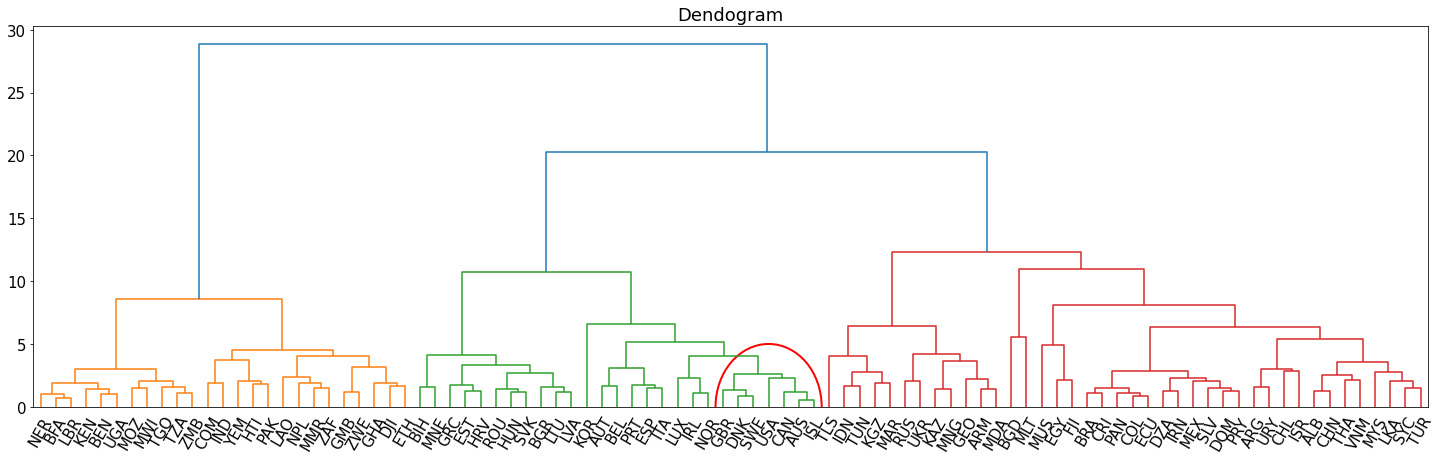

In [6]:
# Agglomerative clustering:
linked = linkage(zscore, 'ward')
plt.figure(figsize = (25,7))
ax = plt.gca()
dendrogram(linked,
           orientation='top',
           labels=country_desc.index,
           distance_sort='descending',
           leaf_rotation = 60,
           show_leaf_counts=True)
plt.tick_params(axis='both', which='major', labelsize=15)
ellipse = Ellipse(xy=(485, 0), width=70, height=10, 
                        edgecolor='red', fc='None', lw=2)
ax.add_patch(ellipse)
_=plt.title("Dendogram", fontsize = 18)

<span style="font-size:14pt">*We have got DNK and GBR as closely related to SWE, also close are the following countries: ISL, AUS, CAN and USA however chosing an other linkage method (here I used Ward), USA doesnt really seems to be that similar.*</span>

In [7]:
# Selecting the listed "similar" countries:
data_c = data[~data["iso_code"].str.contains("_",na=False)].dropna(subset=["iso_code"])
data_selected = data_c.set_index(["iso_code","date"]).loc[["SWE","DNK","GBR","CAN","AUS","ISL"]].unstack("iso_code")

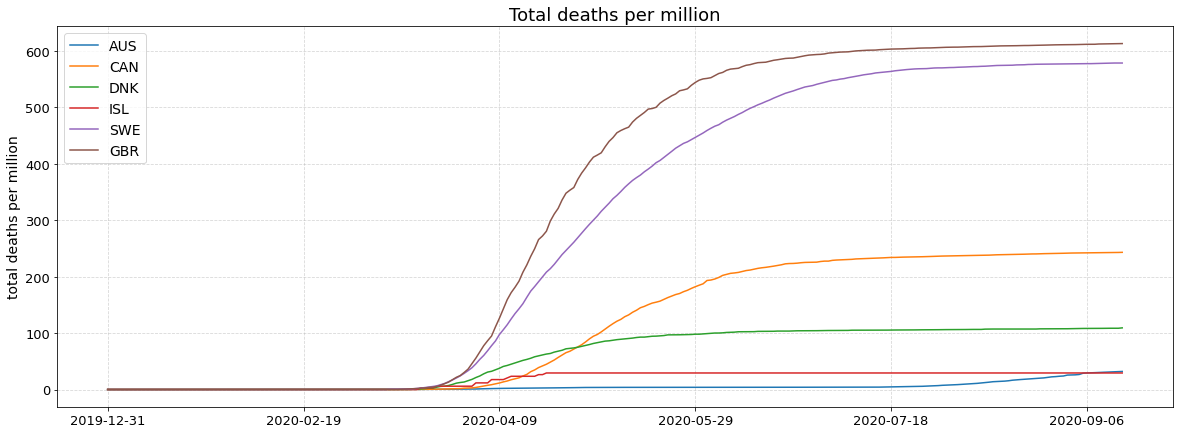

In [8]:
data_selected["total_deaths_per_million"].plot(figsize = (20,7))
plt.title("Total deaths per million", fontsize = 18)
plt.grid(alpha=0.5,linestyle = "--")
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylabel("total deaths per million",fontsize = 14)
plt.xlabel("")
plt.legend(fontsize=14)

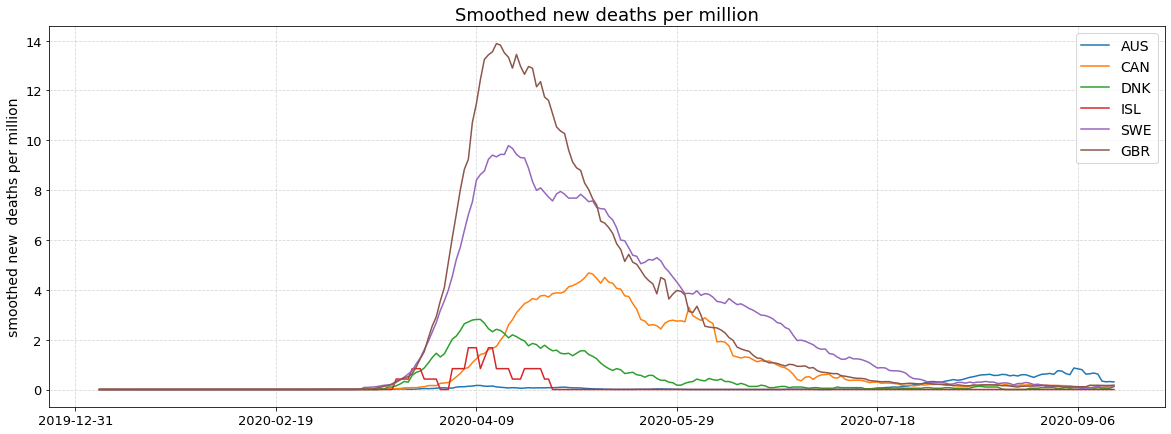

In [9]:
data_selected["new_deaths_smoothed_per_million"].plot(figsize = (20,7))
plt.title("Smoothed new deaths per million", fontsize = 18)
plt.grid(alpha=0.5,linestyle = "--")
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylabel("smoothed new  deaths per million",fontsize = 14)
plt.xlabel("")
plt.legend(fontsize=14)

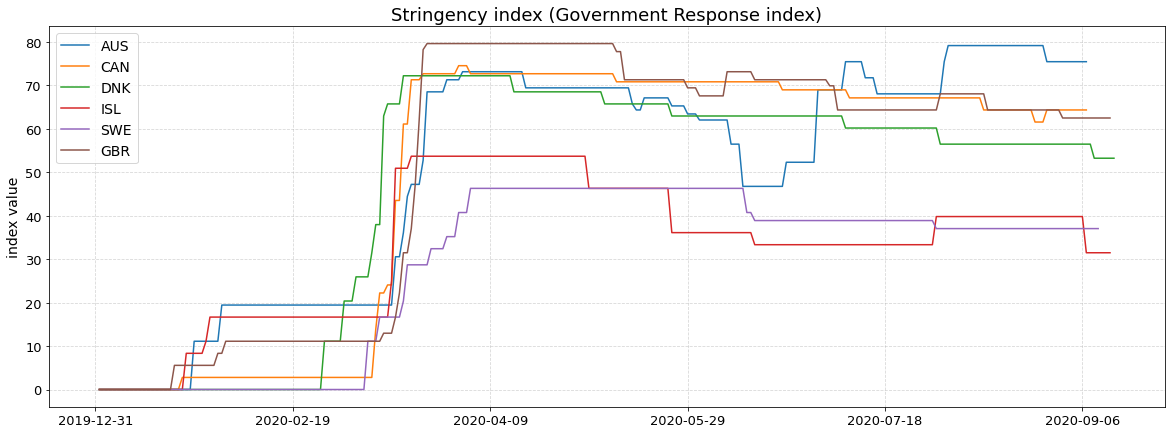

In [10]:
data_selected["stringency_index"].plot(figsize = (20,7))
plt.title("Stringency index (Government Response index)", fontsize = 18)
plt.grid(alpha=0.5,linestyle = "--")
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylabel("index value",fontsize = 14)
plt.xlabel("")
plt.legend(fontsize=14)

https://ourworldindata.org/grapher/covid-stringency-index?time=2020-01-22..latest

<span style="font-size:14pt">*Interesting figures, however it is still hard to infer from the results. Based on the clustering excescise Denmark seems to be the good benchmark and their numbers are much better. Great Brittan have higher total number of deaths even with more government respones, but clearly something went very wrong there. As for similar government restrictions Sweden can be compared to Island, but I suppose Island was well separated from other countries due its island nature it might not be a good benchmark.*</span>

In [11]:
# Countries with the lowest stringency indexes:
data_all = data_c.set_index(["iso_code","date"]).unstack("iso_code")
data_all["stringency_index"].mean().sort_values().head(10)

iso_code
BLR     8.719920
NIC    13.162674
BDI    13.229750
TWN    21.939650
SWE    28.938780
JPN    29.665233
EST    30.489806
ISL    32.925019
NER    33.890888
KHM    34.461790
dtype: float64

In [12]:
# Correlation between the total deaths on 2020/09/14 and the country variables:
total_deaths = data[data["date"] == "2020-09-14"][["iso_code", "total_deaths"]].set_index("iso_code").reindex(country_desc.index)["total_deaths"]
country_desc.apply(lambda x: pearsonr(x, total_deaths)[0])

life_expectancy               0.137613
aged_70_older                 0.076448
extreme_poverty              -0.107491
hospital_beds_per_thousand   -0.079717
human_development_index       0.178138
aged_65_older                 0.086244
gdp_per_capita                0.177122
cardiovasc_death_rate        -0.188750
male_smokers                 -0.163546
diabetes_prevalence           0.175411
female_smokers                0.075212
population_density           -0.042286
median_age                    0.111031
dtype: float64